# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import cirq
import functools as ft

2024-03-26 12:03:43.185090: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [18]:
metrics_file = Path("./output/coingame_maa2c_quantum_nnencode.json")

metrics_file.parent.expanduser().mkdir(parents=True, exist_ok=True)

In [5]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [6]:
def generate_model_CoinGame2_actor_quantum(
    n_layers,
    beta = 1.0,
    name=None,
    ):
    """Single-agent variant of hybrid quantum actor for CoinGame.
    """

    # Shape of observables is already known for CoinGame2.
    obs_shape = (4,3,3)

    # Qubit dimension is pre-determined for CoinGame2 environment.
    # Using `4` to match observable dimension.
    d_qubits = 4

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(d_qubits)
    
    # Generate observables.
    observables = eqmarl.make_observables_CoinGame2(qubits)

    # Define quantum layer.
    qlayer = eqmarl.HybridVariationalEncodingPQC(
        qubits=qubits, 
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        # squash_activation='tanh',
        squash_activation='arctan',
        encoding_layer_cls=eqmarl.ParameterizedRotationLayer_RxRyRz,
        )
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = ft.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(input_size,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Dense(12, activation='relu'), # Embed 4*3*3=36 features into 4*3=12 dimensions. Allows 4-qubit encoding using Rx, Ry, and Rz rotations per qubit.
                keras.layers.Reshape((4,3,)), # Reshape to matrix grid.
                ], name="input-preprocess"),
            qlayer, # Hybrid quantum layer.
            keras.Sequential([
                eqmarl.RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                keras.layers.Softmax(),
                ], name='observables-policy')
        ], name=name)
    return model


# # Shared actor.
# model_actor = generate_model_actor_classical(
#     n_actions=n_actions,
#     units=[256, 128],
#     name=f"actor-classical-shared"
#     )
# optimizer_actor = keras.optimizers.Adam(learning_rate=3e-4)

# Quantum shared actor.
model_actor = generate_model_CoinGame2_actor_quantum(
    n_layers=5,
    name=f"actor-quantum-shared",
    )
# optimizer_actor = [
#     # Classical trainable variable optimizers.
#     keras.optimizers.Adam(learning_rate=3e-4), # Dense weights.
#     keras.optimizers.Adam(learning_rate=3e-4), # Dense bias.
#     # Quantum trainable variable optimizers.
#     keras.optimizers.Adam(learning_rate=1e-2),
#     keras.optimizers.Adam(learning_rate=1e-1),
#     keras.optimizers.Adam(learning_rate=1e-1),
#     ]
optimizer_actor = keras.optimizers.Adam(learning_rate=1e-2)

model_actor.build((None, observation_dim))
model_actor.summary()

Model: "actor-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 3)             444       
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 4)                132       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 4)                4         
 ial)                                                            
                                                                 
Total params: 580
Trainable params: 580
Non-trainable params: 0
_________________________________________________________________


In [7]:
def generate_model_CoinGame2_critic_quantum_partite(
    n_agents,
    n_layers,
    beta = 1.0,
    squash_activation = 'linear', # linear, arctan/atan, tanh
    name=None,
    ):
    """eQMARL variant of hybrid joint quantum critic for CoinGame.
    """

    # Shape of observables is already known for CoinGame2.
    obs_shape = (4,3,3)

    # Qubit dimension is pre-determined for CoinGame2 environment.
    # Using `4` to match observable dimension.
    d_qubits = 4

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(n_agents * d_qubits)

    # Observables is joint Pauli product across all qubits.
    observables = [ft.reduce(lambda x,y: x*y, [cirq.Z(q) for q in qubits])]

    # Define quantum layer.
    qlayer = eqmarl.HybridPartiteVariationalEncodingPQC(
        qubits=qubits, 
        n_parts=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        squash_activation=squash_activation,
        encoding_layer_cls=eqmarl.ParameterizedRotationLayer_RxRyRz,
        )
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = ft.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(n_agents, input_size), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Dense(12, activation='relu'), # Embed 4*3*3=36 features into 4*3=12 dimensions. Allows 4-qubit encoding using Rx, Ry, and Rz rotations per qubit.
                keras.layers.Reshape((n_agents,4,3,)), # Reshape to matrix grid.
                ], name="input-preprocess"),
            qlayer,
            keras.Sequential([
                eqmarl.RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                ], name='observables-value')
        ], name=name)
    return model


# # Classical critic.
# model_critic = generate_model_critic_classical(
#     units=[256, 128],
#     name=f"critic-classical-joint"
#     )
# optimizer_critic = keras.optimizers.Adam(learning_rate=3e-4)

# Quantum joint critic.
model_critic = generate_model_CoinGame2_critic_quantum_partite(
    n_agents=n_agents,
    n_layers=5,
    name=f"critic-quantum-joint",
    )
# optimizer_critic = [
#     # Classical trainable variable optimizers.
#     keras.optimizers.Adam(learning_rate=3e-4), # Dense weights.
#     keras.optimizers.Adam(learning_rate=3e-4), # Dense bias.
#     # Quantum trainable variable optimizers.
#     keras.optimizers.Adam(learning_rate=1e-2),
#     keras.optimizers.Adam(learning_rate=1e-1),
#     keras.optimizers.Adam(learning_rate=1e-1),
#     ]
optimizer_critic = keras.optimizers.Adam(learning_rate=1e-2)

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "critic-quantum-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 2, 4, 3)          444       
 l)                                                              
                                                                 
 HybridPartiteVariationalEnc  (None, 1)                264       
 odingPQC (HybridPartiteVari                                     
 ationalEncodingPQC)                                             
                                                                 
 observables-value (Sequenti  (None, 1)                1         
 al)                                                             
                                                                 
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________


## Training

In [8]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [9]:
# Train models using algorithm.
reward_history, metrics_history = algo.train(n_episodes=3000)

# Save results to file.
algo.save_train_results(metrics_file, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 3000: 100%|██████████| 3000/3000 [2:46:43<00:00,  3.33s/episode, coins_collected=24, discounted_reward=19.1, episode_reward=[11. 13.], own_coin_rate=1, own_coins_collected=24, undiscounted_reward=24]      


In [19]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file)

Text(0.5, 1.0, 'Score')

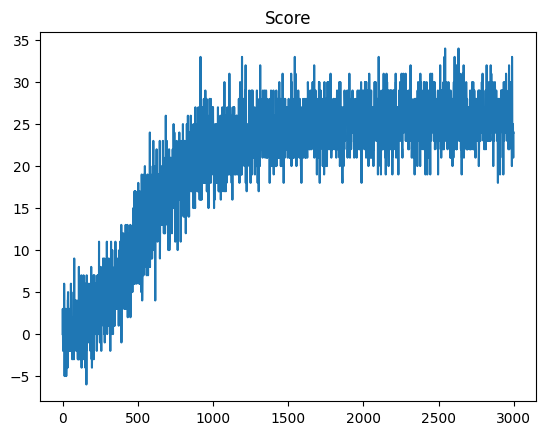

In [20]:
score = np.sum(reward_history, axis=-1)
plt.plot(score)
plt.title('Score')

In [21]:
# plt.plot(reward_history)

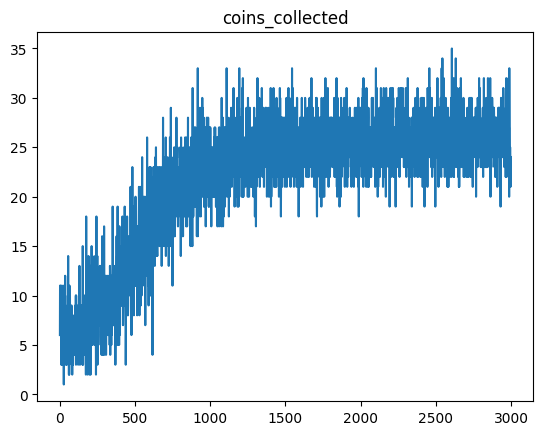

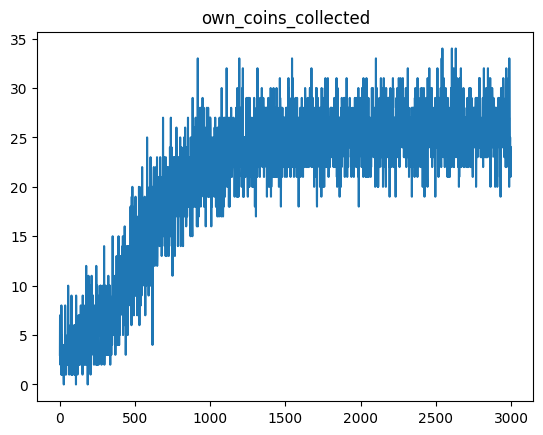

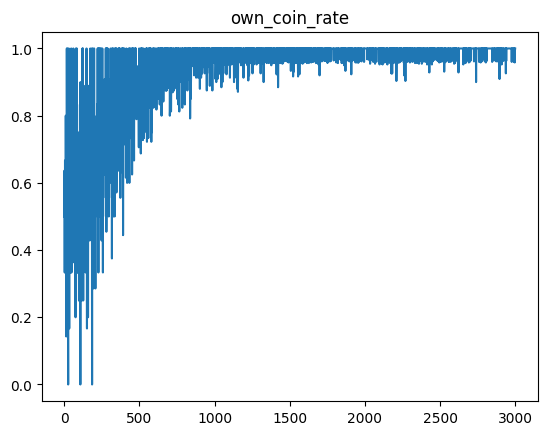

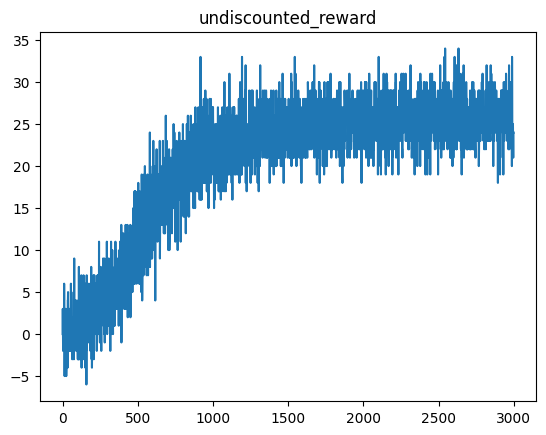

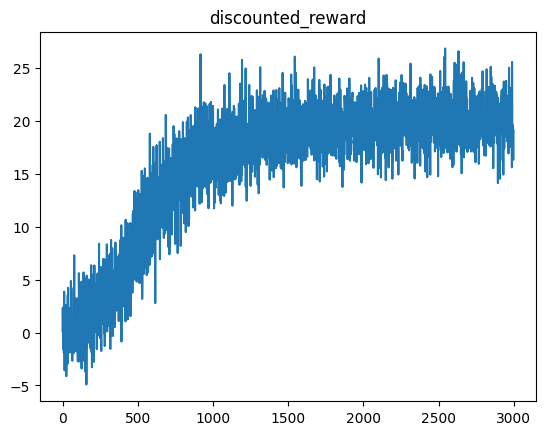

In [22]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v)